# case study : product analysis

A strategy manager wants to get a quick snapshot of a product over a certain period of time.  Please

1. Create visualization(s) to help him/her understand the performance of product through data shown in "data" tab. 
2. Provide a short paragraph to explain/ highlight any interesting/insightful observation.

## 01 setup
import dependencies and load dataset

In [126]:
import pandas as pd
import datetime as dt
import seaborn as sbn
import matplotlib.pyplot as plt

In [56]:
data = pd.read_csv('product_dataset.csv')

In [24]:
data.head()

,Date,Product Type,Status,Total Order,Total GMV
0,02/01/2016,bpjs,created,913,"5,492"
1,04/01/2016,bpjs,created,915,"4,510"
2,05/01/2016,bpjs,created,639,"6,896"
3,06/01/2016,bpjs,created,234,"6,153"
4,08/01/2016,bpjs,created,533,"8,292"


## 02 dataset description


*Fields*

The dataset contains the following fields

| field | description |
| --- | --- |
| Date | — |
| Product Type | — |
| Status | see status table below |
| Total Order | Order units? Not defined in the Data dictionary provided |
| GMV | Gross Merchandise Value. The total amount a customer should pay for a successfully completed order. |

*Status types*

Four product stages were listed, with the presumed sequence in the illustration below

| Status | Description |
| --- | --- |
| Created | The order only until customer receive orderId |
| Failed | Bug in the system |
| Fulfilled | The order was successfully completed |
| Refund | The order was successfully refunded to customers |

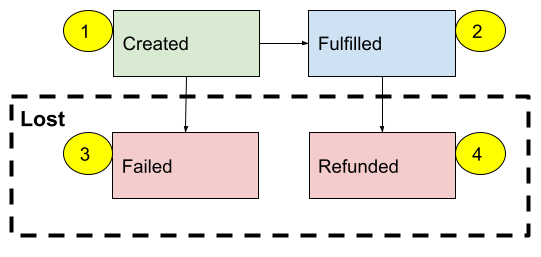

In [4]:
from IPython.display import Image
Image(filename='product stages.png')

## 03 analysis 
### 03.01 dataset conditioning and cleanup

In [57]:
#03.01.01 rename fields to remove spaces
data.rename(columns={
    'Product Type': 'product_type',
    'Total Order': 'total_order',
    'Total GMV': 'total_gmv'
}, inplace=True)

#03.01.02 convert Date from str to datetime class
date_format = '%d/%m/%Y'
data['Date'] = data['Date'].apply(lambda x: dt.datetime.strptime(x, date_format))
data['total_order'] = data['total_order'].apply(lambda x: int(x.replace(',', '')))
data['total_gmv'] = data['total_gmv'].apply(lambda x: int(x.replace(',', '')))

In [26]:
data.head()

,Date,product_type,Status,total_order,total_gmv
0,2016-01-02,bpjs,created,913,5492
1,2016-01-04,bpjs,created,915,4510
2,2016-01-05,bpjs,created,639,6896
3,2016-01-06,bpjs,created,234,6153
4,2016-01-08,bpjs,created,533,8292


### 03.02 basic description

Two basic lines of enquiries are proposed for the initial analysis

1. Cross-section analysis by stage and product type
2. Time series

There is no orderid provided, so cycle time by order is not possible, but stock-flow analysis is possible by product type.

**03.02.01 cross section**

vertical bar charts

1. created, fulfilled by volume, by value ranked by product type (excluding transfers)
2. unit prices
3. conversions - fulfillment %, refund %, failure%

In [58]:
#03.02.03.00.01 exclude transfers
no_xfr = data[data['product_type']!='transfer'].copy()

In [59]:
#03.02.01.01.01 create pivot tables of gmv (value), and orders (volume) by product and status
value_ps_total = pd.pivot_table(no_xfr, values='total_gmv', index='product_type', aggfunc='sum')
volume_ps_total = pd.pivot_table(no_xfr, values='total_order', index='product_type', aggfunc='sum') 

value_ps = pd.pivot_table(no_xfr, values='total_gmv', columns='Status', index='product_type', aggfunc='sum')
volume_ps = pd.pivot_table(no_xfr, values='total_order', columns='Status', index='product_type', aggfunc='sum') 

value_ps['total'] = value_ps_total
volume_ps['total'] = volume_ps_total

#03.02.01.01.02 show units in thousands 
value_ps = value_ps/1000
volume_ps = volume_ps/1000

In [60]:
#03.02.01.01.03 show tables
value_ps.sort_values('fulfilled', ascending=False)

Status,created,failed,fulfilled,refund,total
product_type,,,,,
multifinance,140.088,NaN,76753.945,25216.541,102110.574
pdam,176.836,NaN,46033.009,46480.673,92690.518
bpjs,156.258,NaN,45222.648,43474.813,88853.719
electricity postpaid,22.567,NaN,44833.918,25829.684,70686.169
mobile postpaid,207.314,NaN,42504.964,36373.447,79085.725
e-money,283.947,NaN,42318.546,36878.208,79480.701
games,31.705,43585.209,29092.972,NaN,72709.886
mobile,166.125,NaN,20478.037,17768.227,38412.389
electricity,131.734,NaN,20117.329,18333.618,38582.681


In [61]:
volume_ps.sort_values('fulfilled', ascending=False)

Status,created,failed,fulfilled,refund,total
product_type,,,,,
multifinance,0.910,NaN,3509.855,1511.769,5022.534
data,12.846,NaN,3475.949,2934.872,6423.667
pdam,12.324,NaN,3350.346,3459.424,6822.094
bpjs,14.771,NaN,3310.642,3318.464,6643.877
electricity,25.987,NaN,3275.305,3173.585,6474.877
electricity postpaid,2.810,NaN,3212.227,2016.619,5231.656
games,2.637,3047.99,3164.513,NaN,6215.140
mobile,32.276,NaN,3116.789,3088.038,6237.103
e-money,33.585,NaN,3107.871,2714.357,5855.813


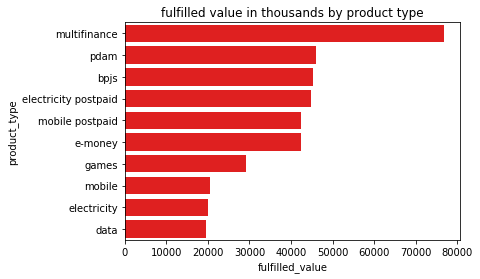

In [143]:
#03.02.01.01.04 show fulfilled vertical bar chart
ax = sbn.barplot(x='fulfilled_value', y='product_type', data=pd.DataFrame({
    'fulfilled_value':value_ps['fulfilled']}).reset_index().sort_values(
    'fulfilled_value', ascending=False), color='red').set(title='fulfilled value in thousands by product type')

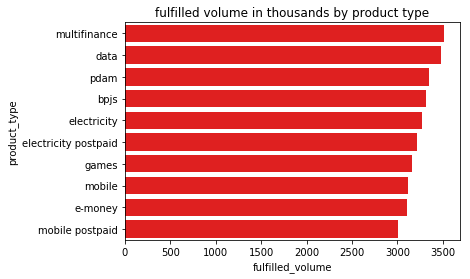

In [142]:
ax = sbn.barplot(x='fulfilled_volume', y='product_type', data=pd.DataFrame({
    'fulfilled_volume':volume_ps['fulfilled']}).reset_index().sort_values(
    'fulfilled_volume', ascending=False), color='red').set(title='fulfilled volume in thousands by product type')

In [75]:
#03.02.01.02 unit costs
unit_cost = value_ps['total']/volume_ps['total'] 

In [77]:
unit_cost.sort_values(ascending=False)

product_type
multifinance            20.330489
pdam                    13.586813
e-money                 13.572958
electricity postpaid    13.511242
bpjs                    13.373775
mobile postpaid         13.309300
games                   11.698833
mobile                   6.158691
electricity              5.958828
data                     5.565663
Name: total, dtype: float64

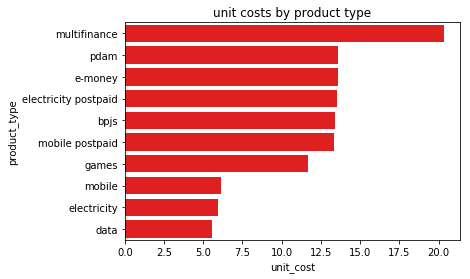

In [141]:
ax = sbn.barplot(x='unit_cost', y='product_type', data=pd.DataFrame({
    'unit_cost':unit_cost}).reset_index().sort_values(
    'unit_cost', ascending=False), color='red').set(title='unit costs by product type')

In [84]:
#03.02.01.03 conversion rates
conversion_rates = pd.DataFrame(
    {'created': volume_ps['created']/volume_ps['total'],
     'failed': volume_ps['failed']/volume_ps['total'],
     'fulfilled': volume_ps['fulfilled']/volume_ps['total'],
     'refunded': volume_ps['refund']/volume_ps['total']
    }
)

In [86]:
conversion_rates.sort_values('fulfilled', ascending=False)

,created,failed,fulfilled,refunded
product_type,,,,
multifinance,0.000181,NaN,0.698822,0.300997
electricity postpaid,0.000537,NaN,0.613998,0.385465
data,0.002000,NaN,0.541116,0.456884
e-money,0.005735,NaN,0.530733,0.463532
games,0.000424,0.490414,0.509162,NaN
electricity,0.004014,NaN,0.505848,0.490138
mobile postpaid,0.004212,NaN,0.505702,0.490086
mobile,0.005175,NaN,0.499717,0.495108
bpjs,0.002223,NaN,0.498300,0.499477


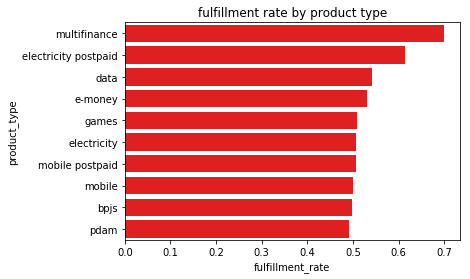

In [140]:
ax = sbn.barplot(x='fulfillment_rate', y='product_type', data=pd.DataFrame({
    'fulfillment_rate':volume_ps['fulfilled']/volume_ps['total']}).reset_index().sort_values(
    'fulfillment_rate', ascending=False), color='red').set(title='fulfillment rate by product type')

### 03.02.01 observations

1. compared to order volume, there is higher variance in unit price between products
2. games have a high failure rate and thus lost opportunity. for every 100 game orders fulfilled, 96 are failed
3. multifinance is the highest product type fulfillment and total orders by value and fulfillment by volume
4. data is the lowest product by fulfillment value, but 2nd highest fulfillment volume
5. mobile postpaid is the lowest product by fulfillment volume, and 5th of 10 fulfillment value
6. multifinance has the highest fulfillment rate 70%, followed by electricity postpaid 61% and all others are in a narrow range 49% - 54%

### 03.02.01 hypothesis and assumptions

1. These product status is the status of the order *at the time of querying the dataset* rather than at the timestamp. Hypothesis is based on the observation that created << fulfilled
2. Unit price = order value / order volume

**03.02.02 time series**

horizontal bar charts

all product types

11. total orders (by volume) fulfilled over time by period (week?)
12. orders failed, refunded over time
13. conversion rates over time fulfillment %, refund %, failure%
14. order volume by product type

21 - 24 by product type (1-3)

In [91]:
#03.02.02.00 create time series dataset

#03.02.02.00.01 get the span of data, number of unique days to decide the resolution (day, week, or month?)
no_days = (no_xfr['Date'].max() - no_xfr['Date'].min())
no_txns = len(no_xfr)
no_products = len(no_xfr['product_type'].unique())
txns_per_day_per_prd = no_txns/(no_products*no_days.days)

In [118]:
no_txns

2020

In [93]:
print('total span %s days and %.2f txns per day per product' % (no_days.days, txns_per_day_per_prd))

total span 402 days and 0.50 txns per day per product


at this level of resolution is < 4 txns per week and <16 txns per month. This would be 13 months total period which will be visually interesting

In [99]:
no_xfr['month_id'] = no_xfr['Date'].apply(lambda x: (x.year-2016)*12+x.month)

In [100]:
#03.02.02.11.01 create time series tables of order volume by month and status
volume_ms_total = pd.pivot_table(no_xfr, values='total_order', index='month_id', aggfunc='sum') 
volume_ms = pd.pivot_table(no_xfr, values='total_order', columns='Status', index='month_id', aggfunc='sum') 
volume_ms['total'] = volume_ms_total

#show units in thousands 
volume_ms = volume_ms/1000

In [101]:
volume_ms

Status,created,failed,fulfilled,refund,total
month_id,,,,,
1,52.926,1128.937,10960.039,7981.132,20123.034
2,39.599,1001.263,10260.566,7906.628,19208.056
3,43.030,868.568,11042.499,8919.530,20873.627
4,2.591,49.222,265.343,321.998,639.154
14,25.030,NaN,NaN,NaN,25.030


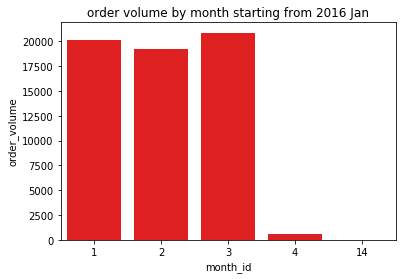

In [154]:
ax = sbn.barplot(x='month_id', y='order_volume', data=pd.DataFrame({
    'order_volume':volume_ms['total']}).reset_index(), color = 'red').set(title='order volume by month starting from 2016 Jan')

so there is a big gap in the dataset, so try again with week bins and limit to the period from 1 Jan 2016 until 1 May 2016

In [104]:
# add week field
nx_2016 = no_xfr[no_xfr.month_id<=4].copy()
nx_2016['week_id'] = nx_2016['Date'].apply(lambda x: x.isocalendar()[1])

In [116]:
#03.02.02.11.02 create time series tables of order volume by week and status
volume_ws_total = pd.pivot_table(nx_2016, values='total_order', index='week_id', aggfunc='sum') 
volume_ws = pd.pivot_table(nx_2016, values='total_order', columns='Status', index='week_id', aggfunc='sum') 
volume_ws['total'] = volume_ws_total

#shift week 53 of 2015 to week 0 of 2016
volume_ws.rename(index={53: 0}, inplace=True)
volume_ws.sort_index(ascending=True, inplace=True)

#show units in thousands 
volume_ws = volume_ws/1000

In [117]:
volume_ws

Status,created,failed,fulfilled,refund,total
week_id,,,,,
0,4.456,102.248,992.793,939.228,2038.725
1,16.201,159.049,2341.230,1623.072,4139.552
2,10.388,274.672,2430.539,1897.092,4612.691
3,4.544,288.089,2674.956,1833.494,4801.083
4,17.337,304.879,2520.521,1688.246,4530.983
5,14.363,255.789,2604.744,2026.766,4901.662
6,9.277,261.394,2780.413,1980.917,5032.001
7,9.736,251.671,2128.459,1802.177,4192.043
8,5.162,178.851,2331.615,1750.019,4265.647


In [120]:
volume_ws.describe()

Status,created,failed,fulfilled,refund,total
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,9.867571,217.713571,2323.460500,1794.949143,4345.990786
std,4.242019,71.218728,479.802472,319.206539,823.038271
min,4.456000,74.612000,992.793000,939.228000,2038.725000
25%,6.627500,167.823000,2323.513500,1703.689250,4210.444000
50%,9.506500,253.730000,2438.788500,1865.293000,4574.063000
75%,12.686250,263.163250,2625.087000,2011.625750,4876.517250
max,17.337000,304.879000,2780.413000,2124.376000,5032.001000


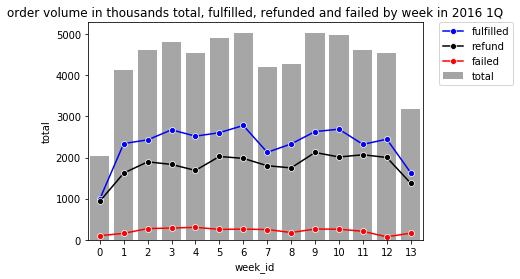

In [155]:
ov_by_week = volume_ws.reset_index()

sbn.lineplot(data = ov_by_week['fulfilled'], marker='o', color='blue', sort = False, label = 'fulfilled')
sbn.lineplot(data = ov_by_week['refund'], marker='o', color='black', sort = False, label = 'refund')
sbn.lineplot(data = ov_by_week['failed'], marker='o', color='red', sort = False, label = 'failed')
sbn.barplot(x='week_id', y='total', data=ov_by_week, alpha=0.7, label = 'total', color='grey').set(
    title='order volume in thousands total, fulfilled, refunded and failed by week in 2016 1Q')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

there is an observable drop-off in orders beginning slightly after week 10 and then rapidly from week 12 onwards. The WHO declared COVID-19 a global pandemic in week 10 and in week 13 Singapore govt announced circuit breaker

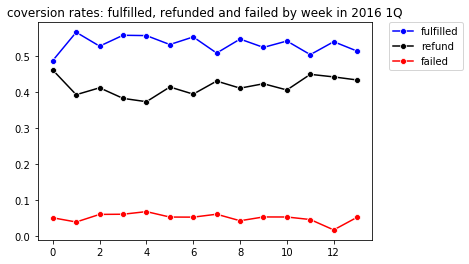

In [156]:
#03.02.02.11.03 conversion rates by week and status
sbn.lineplot(data = ov_by_week['fulfilled']/ov_by_week['total'], marker='o', color='blue', sort = False, label = 'fulfilled')
sbn.lineplot(data = ov_by_week['refund']/ov_by_week['total'], marker='o', color='black', sort = False, label = 'refund')
sbn.lineplot(data = ov_by_week['failed']/ov_by_week['total'], marker='o', color='red', sort = False, label = 'failed').set(
    title='coversion rates: fulfilled, refunded and failed by week in 2016 1Q')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

[Text(0.5, 1.0, 'fulfillment rate by week in 2016 1Q')]

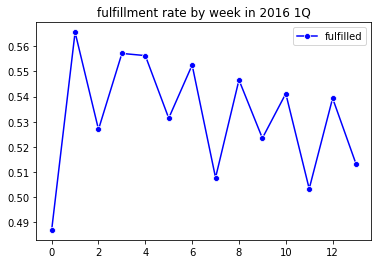

In [157]:
sbn.lineplot(data = ov_by_week['fulfilled']/ov_by_week['total'], 
             marker='o', color='blue', sort = False, label = 'fulfilled').set(
    title='fulfillment rate by week in 2016 1Q')


### 03.02.02 observations

1. Total order volume over the whole 2016-2017 period is discontinuous, suddenly dropping off after March 2016 (COVID pandemic?) and then picking up only briefly in Feb 2017
2. total order volume during 20161Q gradually peaked around 5 mil and then declined gradually before dropping off sharply at the end of March, with the exception of a two week dip in weeks 7 and 8 around 4.2 mil
3. overall fulfillment rates varied on a steady downward trend from 55% in Jan 2016 to just under 53% by the end of March 2016

### 03.02.02 hypothesis and assumptions

1. Use weekly bins due to visual appeal of 13 weeks and statistical sample of ~ 15 txns per product per bin
2. drop the outlier month 2017 Feb